In [52]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
from time import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import numpy as np
import pandas as pd
import pickle

from lang import LanguageDataset
from preprocessing import (
    get_vocab,
    word2idx,
    idx2word,
    add_sentence_tokens,
    trim_outliers,
)
from nltk.tokenize import wordpunct_tokenize
from nltk.translate import bleu_score
from gensim.models import Word2Vec
from model import *
from constants import *

df = pd.read_csv("../data/preprocessed/preprocessed_train.csv")
df["en_processed"] = df["en_processed"].apply(wordpunct_tokenize)
df["hu_processed"] = df["hu_processed"].apply(wordpunct_tokenize)
df = trim_outliers(df, "en_processed", MAX_WORDS)
df = trim_outliers(df, "hu_processed", MAX_WORDS)
print(len(df.index))
df["en_processed"] = df["en_processed"].apply(add_sentence_tokens)
df["hu_processed"] = df["hu_processed"].apply(add_sentence_tokens)

input_sentences = df["en_processed"]
output_sentences = df["hu_processed"]

In [55]:
(input_sentences)

["['<SOS>', 'i', 'am', 'in', 'close', 'contact', 'with', 'his', 'family', '<EOS>']",
 "['<SOS>', 'i', 'am', 'in', 'favour', 'of', 'adult', 'education', '<EOS>']",
 "['<SOS>', 'no', '<EOS>']",
 "['<SOS>', 'i', 'must', 'say', 'three', 'things', 'to', 'you', '<EOS>']",
 "['<SOS>', 'the', 'next', 'item', 'is', 'the', 'vote', '<EOS>']",
 "['<SOS>', 'i', 'urge', 'it', 'to', 'vote', 'with', 'me', '<EOS>']",
 "['<SOS>', 'politicians', 'should', 'set', 'aside', 'their', 'arrogance', 'and', 'comfortable', 'situation', '<EOS>']",
 "['<SOS>', 'forwarding', 'of', 'texts', 'adopted', 'during', 'the', 'sitting', 'see', 'minutes', '<EOS>']",
 "['<SOS>', 'before', 'lunch', 'we', 'were', 'told', 'that', 'there', 'were', 'fourteen', 'members', '<EOS>']",
 "['<SOS>', 'why', '<EOS>']",
 "['<SOS>', 'euromed', '<EOS>']",
 "['<SOS>', 'that', 'is', 'our', 'objective', ',', 'mr', 'president', '<EOS>']",
 "['<SOS>', 'the', 'council', 'also', 'seeks', 'to', 'promote', 'solidarity', 'by', 'other', 'means', '<EOS>'

In [47]:
input_pretrained_embeddings = torch.load(
    "../models/w2v_embeddings/embeddings_cbow_en.pt"
)
output_pretrained_embeddings = torch.load(
    "../models/w2v_embeddings/embeddings_cbow_hu.pt"
)

with open("../models/word2index/word2index_cbow_en.pkl", "rb") as fp:
    input_word2idx = pickle.load(fp)
with open("../models/word2index/word2index_cbow_hu.pkl", "rb") as fp:
    output_word2idx = pickle.load(fp)
with open("../models/word2index/index2word_cbow_en.pkl", "rb") as fp:
    input_idx2word = pickle.load(fp)
with open("../models/word2index/index2word_cbow_hu.pkl", "rb") as fp:
    output_idx2word = pickle.load(fp)

In [48]:
encoder = EncoderRNN(
    len(input_word2idx), EMBEDDING_DIM, input_pretrained_embeddings
).to(device)
decoder = AttnDecoderRNN(
    EMBEDDING_DIM, len(output_word2idx), output_pretrained_embeddings
).to(device)

translation = "en_hu"
embedding = "cbow"
attention = "attention"

# load trained model
encoder.load_state_dict(
    torch.load(
        f"../models/{translation}/{embedding}/{attention}/encoder_{MAX_WORDS}_100.model"
    )
)
encoder.eval()
decoder.load_state_dict(
    torch.load(
        f"../models/{translation}/{embedding}/{attention}/decoder_{MAX_WORDS}_100.model"
    )
)
decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(8540, 100)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=100, out_features=100, bias=True)
    (Ua): Linear(in_features=100, out_features=100, bias=True)
    (Va): Linear(in_features=100, out_features=1, bias=True)
  )
  (gru): GRU(200, 100, batch_first=True)
  (out): Linear(in_features=100, out_features=8540, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [49]:
predictions = [
    evaluate(encoder, decoder, test_input_sentence, input_word2idx, output_idx2word)[
        1:-1
    ]
    for test_input_sentence in input_sentences
]
targets = [sentence[1:-1] for sentence in output_sentences]

bleu_scores = []
for prediction, target in zip(predictions, targets):
    bleu_scores.append(
        bleu_score.sentence_bleu([target], prediction, weights=(0.5, 0.5, 0, 0))
    )

bleu_scores = np.array(bleu_scores)

# bleu_scores = bleu_score.corpus_bleu(targets, predictions, weights = (1, 0, 0 ,0))

KeyError: '['

In [39]:
best_ones = np.argsort(bleu_scores)[-3:]
worst_ones = np.argsort(bleu_scores)[:3]

In [40]:
for i in best_ones:
    print(bleu_scores[i])
    print(input_sentences[i])
    print(targets[i])
    print(predictions[i])

1.0
['<SOS>', 'thank', 'you', '.', '<EOS>']
['köszönöm', '.']
['köszönöm', '.']
1.0
['<SOS>', 'documents', 'received', 'see', 'minutes', '<EOS>']
['dokumentumok', 'benyújtása', 'lásd', 'a', 'jegyzőkönyvet']
['dokumentumok', 'benyújtása', 'lásd', 'a', 'jegyzőkönyvet']
1.0
['<SOS>', 'oral', 'questions', 'and', 'written', 'declarations', 'see', 'minutes', '<EOS>']
['szóbeli', 'választ', 'igénylő', 'kérdések', 'és', 'írásbeli', 'nyilatkozatok', 'lásd', 'a', 'jegyzőkönyvet']
['szóbeli', 'választ', 'igénylő', 'kérdések', 'és', 'írásbeli', 'nyilatkozatok', 'lásd', 'a', 'jegyzőkönyvet']


In [41]:
for i in worst_ones:
    print(bleu_scores[i])
    print(input_sentences[i])
    print(targets[i])
    print(predictions[i])

0.0
['<SOS>', 'we', 'must', 'drive', 'forward', 'the', 'doha', 'round', '.', '<EOS>']
['elő', 'kell', 'segítenünk', 'a', 'dohai', 'forduló', 'előrehaladását', '.']
['vissza', 'akarunk', 'térni', 'nizzához', '?']
0.0
['<SOS>', 'batteries', 'and', 'accumulators', 'and', 'waste', 'batteries', 'and', 'accumulators', '<EOS>']
['elemek', ',', 'akkumulátorok', 'és', 'hulladékelemek']
['tárgy', 'a', 'konstantinápolyi', 'patriarchátus', 'ökumenikus', 'jellege']
0.0
['<SOS>', 'eurozone', '<EOS>']
['eurózóna']
['euromatrica']


In [42]:
print(bleu_scores[best_ones])
print(input_sentences[best_ones])
print(output_sentences[best_ones])
# print(predictions[best_ones])

[1. 1. 1.]
278                        [<SOS>, thank, you, ., <EOS>]
40     [<SOS>, documents, received, see, minutes, <EOS>]
0      [<SOS>, oral, questions, and, written, declara...
Name: en_processed, dtype: object
278                          [<SOS>, köszönöm, ., <EOS>]
40     [<SOS>, dokumentumok, benyújtása, lásd, a, jeg...
0      [<SOS>, szóbeli, választ, igénylő, kérdések, é...
Name: hu_processed, dtype: object


(618,)
0.0
1.0
0.16219886370918873


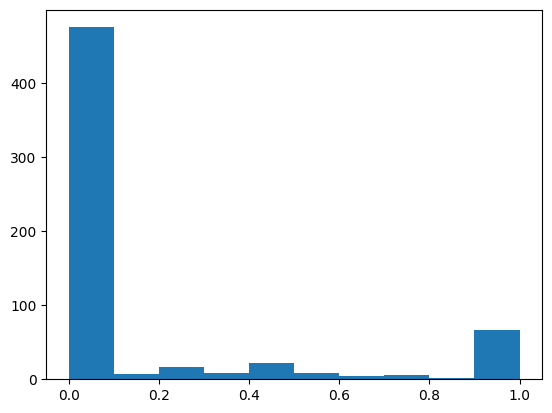

In [43]:
print(bleu_scores.shape)
print(bleu_scores.min())
print(bleu_scores.max())
print(bleu_scores.mean())
plt.hist(bleu_scores)
plt.show()

In [44]:
print(np.unique(bleu_scores, return_counts=True))

(array([0.00000000e+000, 2.13685040e-155, 2.30039518e-155, 2.35350700e-155,
       2.45410269e-155, 2.74377022e-155, 3.47062531e-155, 3.52307070e-155,
       3.66109100e-155, 3.67279754e-155, 3.69359565e-155, 4.10727330e-155,
       4.23681068e-155, 4.23903132e-155, 4.36346768e-155, 4.42162527e-155,
       4.47166665e-155, 4.71706886e-155, 4.88743649e-155, 4.97222715e-155,
       4.98237437e-155, 5.15482798e-155, 5.17756455e-155, 5.19412010e-155,
       5.22353306e-155, 5.27384331e-155, 5.46170598e-155, 5.63797565e-155,
       5.80856160e-155, 5.99175512e-155, 6.08970971e-155, 6.17087517e-155,
       6.25312243e-155, 6.29232312e-155, 6.36147195e-155, 6.39749532e-155,
       6.58196259e-155, 6.67094275e-155, 6.91187897e-155, 7.03179108e-155,
       7.11400603e-155, 7.29002764e-155, 7.33837136e-155, 7.45834073e-155,
       7.70649047e-155, 7.72401867e-155, 7.97330163e-155, 8.06122493e-155,
       8.17020292e-155, 8.21454660e-155, 8.46528832e-155, 8.61215006e-155,
       8.72693535e-155, 